<a href="https://colab.research.google.com/github/Heity94/WalkieLookie/blob/main/notebooks/PH_Routing_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install requirements { display-mode: "form" }
!pip install osmnx -q
!pip install geopy -q

     |████████████████████████████████| 95 kB 2.8 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 1.0 MB 46.3 MB/s 
     |████████████████████████████████| 1.0 MB 41.4 MB/s 
     |████████████████████████████████| 11.2 MB 41.4 MB/s 
     |████████████████████████████████| 6.3 MB 39.0 MB/s 
     |████████████████████████████████| 16.7 MB 388 kB/s 
     |████████████████████████████████| 930 kB 12.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


❗**Attention**: In order to make the code work you need to **restart your runtime** after executing the cell above ☝ (not just reloading the web page).<br> 
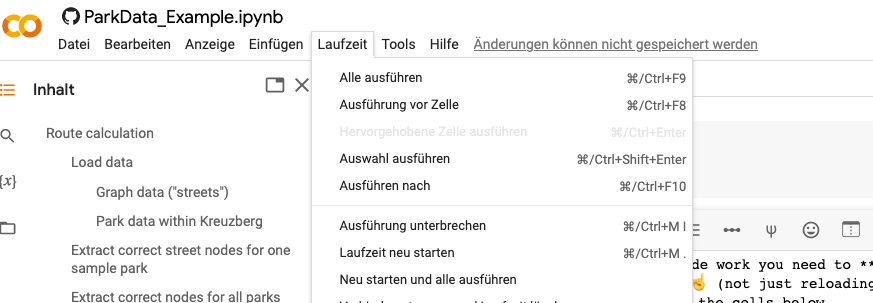
<br>
After that you can continue with running the cells below 

In [1]:
#@title Imports
import pickle
import folium
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
ox.config(log_console=True, use_cache=True)
from geopy.geocoders import Nominatim
from networkx.algorithms import approximation as approx # Greedy salesman algorithms
import sklearn
from ast import literal_eval

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Link to common google drive folder (you have to add a link from the foder to your drive first)
data_path = "/content/drive/MyDrive/BPI Lap WalkieLookie/Data/"
#data_path = "/content/drive/MyDrive/WalkieLookie/BPI Lap WalkieLookie/Data" #Roger
#data_path="/home/valentin_werner/Philipps_Playground/WalkieLookie/data/" #Philipp Zeno

# Create own Traveling Salesman Function

In [5]:
#Load DataFrame with nodes of interest (NOI)
places_noi = pd.read_csv(data_path+"bln_xberg_parks_park_nodes_wo_NaN.csv", index_col=0)
places_noi["nodes_within_park"]=places_noi.nodes_within_park.apply(lambda x: literal_eval(x)) #Change type to list

In [23]:
#load street data from berlin
with open(data_path+'graph_berlin.obj', 'rb') as fp:
  street_graph = pickle.load(fp)

### Create individual functions

In [4]:
# User inut
user_time = 10 #minutes
start_address = "Zossener Straße 11, 10961 Berlin"
round_trip=True
avg_speed =5 
time_margin = 10
optimizer = "time"

In [8]:
# Function to calculate center node (if possible), otherwise retunr "No center found"
def center_nodes(street_graph, places_nodes_on_map):
  try: 
    return nx.center(street_graph.subgraph(places_nodes_on_map))[0] #take first center node (in case there are more than 1)
  except:
    return "No center found"

In [9]:
def get_noi(street_graph, places_noi):

  street_nodes = set(street_graph.nodes())

  # Create column whihc only includes nodes which are also within the berlin graph dats (streets)
  places_noi["park_nodes_within_graph"] = places_noi.nodes_within_park.apply(lambda x: [node for node in x if node in street_graph])

  places_noi = places_noi[places_noi.park_nodes_within_graph.apply(lambda x: len(x)) > 0].copy() #Filter out empty parks

  # Get center node for each park
  places_noi["center_node"] = places_noi.park_nodes_within_graph.apply(lambda x: center_nodes(street_graph, x))

  # filter out parks without center (for now)
  places_noi = places_noi[places_noi.center_node!="No center found"].copy()

  # Select center park nodes and store as list for route planning
  nodes_to_visit = places_noi.loc[:,"center_node"].to_list()

  return places_noi, nodes_to_visit

In [10]:
def add_start_end_node(start_address, street_graph, nodes_to_visit, end_address=None):
  '''Add start (and end address) to list of nodes which should be visited'''

  locator = Nominatim(user_agent = "myapp")

  # stores the start and end points as geopy.point.Point objects
  start_latlng = locator.geocode(start_address).point
  #end_latlng = locator.geocode(end_location).point

  orig_node = ox.distance.nearest_nodes(street_graph, start_latlng[1], start_latlng[0]) #graph, long, lat

  nodes_to_visit = [orig_node]+nodes_to_visit #add start node tto list to visit

  return nodes_to_visit

In [11]:
def caculate_route(street_graph, nodes_to_visit, cycle=True):

  calc_route = approx.traveling_salesman_problem(street_graph, nodes=nodes_to_visit, cycle=cycle)#, weight="length")

  return calc_route

In [12]:
def get_route_stats(calc_route, street_graph):
  '''Get total length and travel time of calculated route'''
    
  # Sum up travel time and distance
  cols = ['osmid', 'length']#, 'travel_time']
  attrs = ox.utils_graph.get_route_edge_attributes(street_graph, calc_route)
  df_route = pd.DataFrame(attrs)[cols]
  
  length_m = df_route.length.sum().round().astype("int")
  travel_time_min = round((df_route.length.sum()/5000)*60)

  return length_m, travel_time_min

In [13]:
def inital_nodes_to_consider(user_time, nodes_to_visit_final, street_graph, optimizer="time"):

    # given on time: take the starting address and x number of nodes from list 
    x = int(user_time/5) #one place of interest for each 5 minutes
    if x>len(nodes_to_visit_final[1:]): # if number of theoretical nodes to visit is higher than the points of interest in the list take lenght of list
        x = len(nodes_to_visit_final[1:])

    start_node = nodes_to_visit_final[0] #extract start node

    #notes_to_visit_small = np.random.choice(nodes_to_visit_final[1:], x, replace=False).tolist() #sample

    #instead of random sampling of nodes to visit we calculate the distance from the start address and order the list accordingly and then slice it 
    tmp_dict={}

    for node in nodes_to_visit_final[1:]:
        
        shortest_route = nx.shortest_path(street_graph,
                                    start_node,
                                    node,
                                    weight=optimizer)

        #Calculate route statistics for each node
        length_m, travel_time_min = get_route_stats(shortest_route, street_graph)
        
        # Add route and stats to tmp_dict
        tmp_dict[node]={"shortest_path": shortest_route,
                        "length_m": length_m,
                        "travel_time_min": travel_time_min}

    # select shortest path and append to final path list
    df_tmp = pd.DataFrame.from_dict(tmp_dict, orient="index").sort_values(by=["travel_time_min"], ascending=True)
    notes_to_visit_sorted = df_tmp.index.to_list()
    
    notes_to_visit_small = notes_to_visit_sorted[:x]

    return notes_to_visit_small, notes_to_visit_sorted, x, start_node


In [14]:
def create_walking_route(street_graph,  start_node, notes_to_visit_small, round_trip):

    final_path = [] #list to store all the final paths

    iterrations = len(notes_to_visit_small) # number of times we heave to run a for loop

    for i in range(iterrations):

        # from the starting address calculate shortest path to all other nodes and store distance in list
        tmp_dict={}

        for node in notes_to_visit_small:
            
            shortest_route = nx.shortest_path(street_graph,
                                        start_node,
                                        node,
                                        weight=optimizer)

            #Calculate route statistics for each node
            length_m, travel_time_min = get_route_stats(shortest_route, street_graph)
            
            # Add route and stats to tmp_dict
            tmp_dict[node]={"shortest_path": shortest_route,
                            "length_m": length_m,
                            "travel_time_min": travel_time_min}

        # select shortest path and append to final path list
        df_tmp = pd.DataFrame.from_dict(tmp_dict, orient="index")
        node_sh_path_overall = df_tmp.travel_time_min.idxmin()
        shortest_path_overall = df_tmp.loc[node_sh_path_overall, "shortest_path"]
        final_path.append(shortest_path_overall[:-1]) #add all nodes except the last (because the start of next will start at same route)

        start_node = notes_to_visit_small.pop(notes_to_visit_small.index(node_sh_path_overall)) #remove new start node from list and set as new start point for next iterration

    #If it is a round trip add one more path from last point to start address to list
    if round_trip==True:

        shortest_route = nx.shortest_path(street_graph,
                                start_node,
                                nodes_to_visit_final[0],
                                weight=optimizer)

        final_path.append(shortest_route)


    final_path_flat = [x for xs in final_path for x in xs]

    #Calculate route statistics for each node
    length_m, travel_time_min = get_route_stats(final_path_flat, street_graph)

    return final_path_flat, length_m, travel_time_min

In [15]:
def evaluate_iterrate_route(final_path_flat, length_m, travel_time_min, notes_to_visit_sorted, x, start_node, user_time, street_graph, round_trip, time_margin=10):

    x_init = None

    #Check if travel time is in between +-10 minutes from user time -> if yes return route
    while not ((travel_time_min<=user_time+time_margin) & (travel_time_min>=user_time-time_margin))|(x_init==x):
        
        #save inital x
        x_init = x

        #Check if travel time much smaller than the user time -> if yes add more route points
        if (travel_time_min<(user_time+time_margin)):
            x+= 1 #(user_time-travel_time_min)/5
        elif (travel_time_min>(user_time+time_margin)):
            x-= 1 #(user_time-travel_time_min)/5
        
        #update nodes_to_visist
        notes_to_visit_small = notes_to_visit_sorted[:x]
        final_path_flat, length_m, travel_time_min = create_walking_route(street_graph,start_node,notes_to_visit_small, round_trip=round_trip)


    print("Route found")
    return final_path_flat, length_m, travel_time_min, [node for node in notes_to_visit_sorted if node in final_path_flat]

    

## Test functions and plot route

In [48]:
# User inut
user_time = 60 #minutes
start_address = "Zossener Straße 11, 10961 Berlin"
round_trip=True
avg_speed =5 
time_margin = 10
optimizer = "time"

In [49]:
places_noi, nodes_to_visit = get_noi(street_graph, places_noi)
nodes_to_visit_final = add_start_end_node(start_address, street_graph, nodes_to_visit)
notes_to_visit_small, notes_to_visit_sorted, x, start_node = inital_nodes_to_consider(user_time, nodes_to_visit_final, street_graph, optimizer=optimizer)

In [50]:
final_path_flat, length_m, travel_time_min = create_walking_route(street_graph,  start_node, notes_to_visit_small, round_trip)
final_path_flat, length_m, travel_time_min, visited_nodes = evaluate_iterrate_route(final_path_flat, length_m, travel_time_min, notes_to_visit_sorted, x, start_node, user_time, street_graph, round_trip, time_margin)

Route found


In [51]:
print("Route length:", length_m)
print("Estimated Travel time:", travel_time_min)
print("Defined Timeframe from user:", user_time)

Route length: 5598
Estimated Travel time: 67
Defined Timeframe from user: 60


In [55]:
#Plot final route
route_plot =ox.plot_route_folium(street_graph, final_path_flat)

# Add marker for start location
start_loc = final_path_flat[0]
latlng_start = (street_graph.nodes()[start_loc]["y"], street_graph.nodes()[start_loc]["x"])
marker = folium.Marker(
            location = latlng_start,
            icon = folium.Icon(color='red'))

marker.add_to(route_plot)

# Add markers for nodes along the route
for i, park in enumerate(visited_nodes):
  latlng_parks = (street_graph.nodes()[park]["y"], street_graph.nodes()[park]["x"])
  marker = folium.Marker(
              location = latlng_parks,
              icon = folium.Icon(color='green'))

  marker.add_to(route_plot)

route_plot #show plot